## 0. Average number of Dutch tweets per day: 633,113

In [1]:
import datetime
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import re

In [12]:
ANNOTATIONFILENUNL = "annotations-mondkapje-nunl.txt"
ANNOTATIONFILETWITTER = "annotations-mondkapje-twitter.txt"
COUNT = "count"
CSVSUFFIX = ".csv"
DATADIR = "./"
DATESFILENUNL = "dates-mondkapje-nunl.csv"
DATESFILETWITTER = "dates-mondkapje-twitter.csv"
DATE = "date"
DATEFORMATHOUR = "%Y%m%d-%H"
ELECTION = "election"
FIGXSIZE = 14
FIGYSIZE = 7
FILEALL2019 = "ALL-2019.csv"
FILEALL2020 = "ALL-2020.csv"
FONTSIZE = 14
ID = "id"
PRESSCONFERENCE = "press conference"
RIVMCOUNT = "Aantal"
RIVMDATAFILE = "rivm_NL_covid19_national_by_date_latest.csv"
RIVMDATEDATA = "Datum"
RIVMDATEIC = "Date"
RIVMDATEFORMAT = "%Y-%m-%d"
RIVMDEATHS = "Overleden"
RIVMHOSPITALIZED = "Ziekenhuisopname"
RIVMICFILE = "lcps_ic.csv"
RIVMINFECTED = "Totaal"
RIVMTYPE = "Type"
SENTIMENT = "sentiment"
TERRORATTACK = "terror attack"
ELECTIONLIST = ["20200320-12"]
TERRORATTACKLIST = ["20200315-12","20200318-12"]
PRESSCONFERENCELIST = ["20200312-12","20200315-12","20200317-12","20200319-12","20200323-12","20200331-12",\
                       "20200407-12","20200415-12","20200421-12","20200429-12","20200506-12","20200513-12",\
                       "20200519-12"]

In [3]:
def makeSentimentPerDay(sentimentPerHour):
    sentimentPerDay = {}
    for hour in sentimentPerHour.index:
        day = re.sub("..$","12",hour)
        if not day in sentimentPerDay: sentimentPerDay[day] = {SENTIMENT:0,COUNT:0}
        sentimentPerDay[day][SENTIMENT] += sentimentPerHour.loc[hour][SENTIMENT]*sentimentPerHour.loc[hour][COUNT]
        sentimentPerDay[day][COUNT] += sentimentPerHour.loc[hour][COUNT]
    for day in sentimentPerDay:
        sentimentPerDay[day][SENTIMENT] /= sentimentPerDay[day][COUNT]
    return(pd.DataFrame(sentimentPerDay).T)

In [4]:
sentimentPerHour = pd.read_csv(DATADIR+FILEALL2020,index_col=DATE)
sentimentPerDay = makeSentimentPerDay(sentimentPerHour)
print("Average number of Dutch tweets per day from {0} until {1}: {2}".format(\
    sentimentPerDay.index[0][0:8],sentimentPerDay.index[-1][0:8],round(sentimentPerDay[COUNT].mean())))

Average number of Dutch tweets per day from 20200227 until 20200521: 633113


## 1. Graph of daily frequecies of tweets with keywords

In [34]:
queries1 = {}
for query in "topicwords corona covid rivm mondkapje".split():
    queries1[query] = makeSentimentPerDay(pd.read_csv(DATADIR+query+CSVSUFFIX,index_col=DATE))

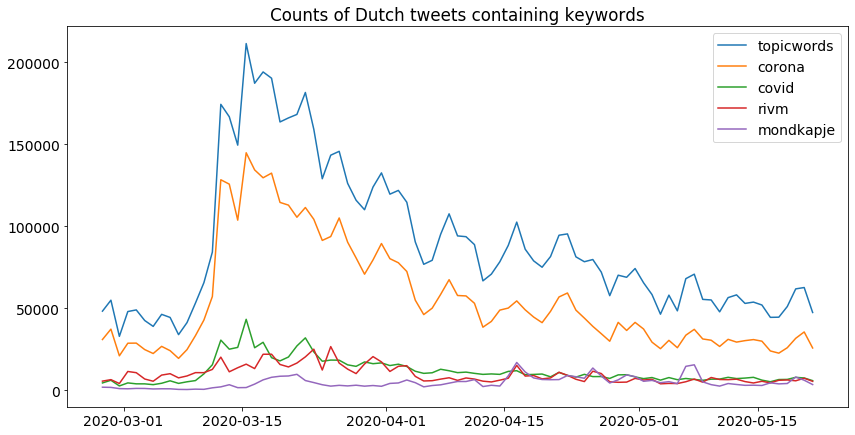

In [35]:
matplotlib.rc("font",**{"size":FONTSIZE})

fig,ax = plt.subplots(figsize=(FIGXSIZE,FIGYSIZE))
for query in "topicwords corona covid rivm mondkapje".split():
    ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in queries1[query].index],\
                 [queries1[query].loc[key][COUNT] for key in queries1[query].index],\
                 xdate=True,fmt="-",label=query)
plt.title("Counts of Dutch tweets containing keywords")
dummy = ax.legend()

## 2. Graph of daily average sentiment of tweets with topic words

In [36]:
queries2 = {}
for query in "topicwords".split():
    queries2[query] = makeSentimentPerDay(pd.read_csv(DATADIR+query+CSVSUFFIX,index_col=DATE))

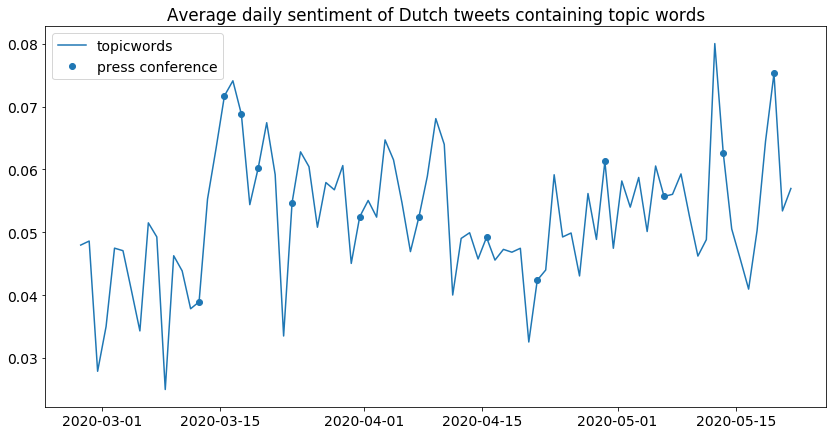

In [37]:
fig,ax = plt.subplots(figsize=(FIGXSIZE,FIGYSIZE))
for query in "topicwords".split():
    lineData = ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in queries2[query].index],\
                            [queries2[query].loc[key][SENTIMENT] for key in queries2[query].index],\
                            xdate=True,fmt="-",label=query)
    color = lineData[-1].get_color()
    ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in PRESSCONFERENCELIST],
                         [queries2[query].loc[key][SENTIMENT] for key in PRESSCONFERENCELIST],\
                         fmt="o",color=color,label=PRESSCONFERENCE)
plt.title("Average daily sentiment of Dutch tweets containing topic words")
dummy = ax.legend()

## 3. RIVM disease data

In [17]:
dataRivm = pd.read_csv(DATADIR+RIVMDATAFILE,index_col=RIVMDATEDATA)
dataIc = pd.read_csv(DATADIR+RIVMICFILE,index_col=RIVMDATEIC)
dataRivmInfected = dataRivm.loc[dataRivm[RIVMTYPE] == RIVMINFECTED]
dataRivmDeaths = dataRivm.loc[dataRivm[RIVMTYPE] == RIVMDEATHS]
dataRivmHospitalized = dataRivm.loc[dataRivm[RIVMTYPE] == RIVMHOSPITALIZED]

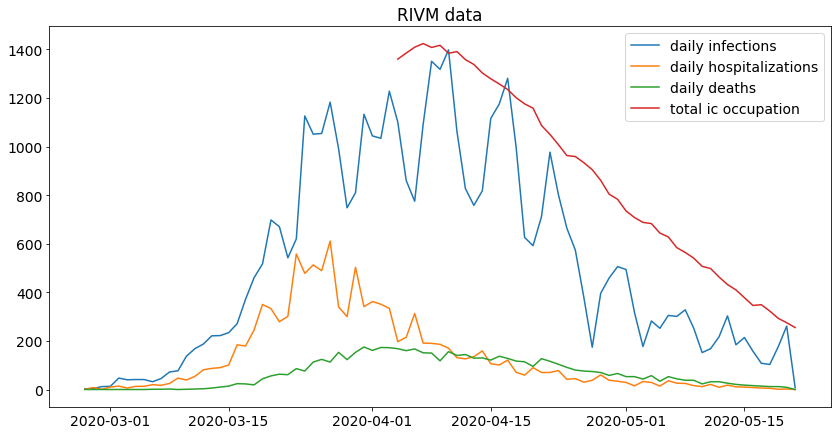

In [19]:
fig,ax = plt.subplots(figsize=(FIGXSIZE,FIGYSIZE))
ax.plot_date([datetime.datetime.strptime(key,RIVMDATEFORMAT) for key in dataRivmInfected.index],\
             [dataRivmInfected.loc[key][RIVMCOUNT] for key in dataRivmInfected.index],\
             xdate=True,fmt="-",label="daily infections")
ax.plot_date([datetime.datetime.strptime(key,RIVMDATEFORMAT) for key in dataRivmHospitalized.index],\
             [dataRivmHospitalized.loc[key][RIVMCOUNT] for key in dataRivmHospitalized.index],\
             xdate=True,fmt="-",label="daily hospitalizations")
ax.plot_date([datetime.datetime.strptime(key,RIVMDATEFORMAT) for key in dataRivmDeaths.index],\
             [dataRivmDeaths.loc[key][RIVMCOUNT] for key in dataRivmDeaths.index],\
             xdate=True,fmt="-",label="daily deaths")
ax.plot_date([datetime.datetime.strptime(key,RIVMDATEFORMAT) for key in dataIc.index],\
             [dataIc.loc[key][RIVMCOUNT] for key in dataIc.index],\
             xdate=True,fmt="-",label="total ic occupation")
plt.title("RIVM data")
dummy = ax.legend()

## 4. Tweet counts per day

In [20]:
def changeYearTo2020(dataIn):
    dataOut = {}
    for dateString in dataIn.index:
        dateString2020 = re.sub(r"20[0-9][0-9]","2020",dateString)
        dataOut[dateString2020] = {SENTIMENT:dataIn.loc[dateString][SENTIMENT],COUNT:dataIn.loc[dateString][COUNT]}
    return(pd.DataFrame(dataOut).T)

In [21]:
sentimentPerDay2020 = makeSentimentPerDay(pd.read_csv(DATADIR+FILEALL2020,index_col=DATE))
sentimentPerDay2019 = changeYearTo2020(makeSentimentPerDay(pd.read_csv(DATADIR+FILEALL2019,index_col=DATE)))

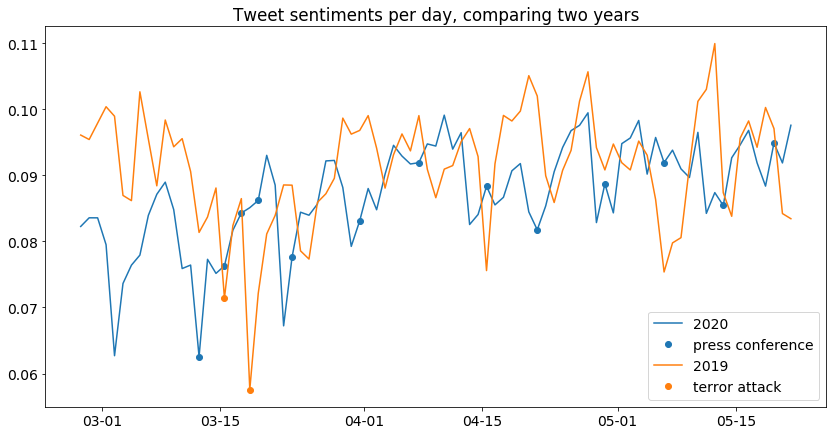

In [22]:
plotInfo = SENTIMENT
fig,ax = plt.subplots(figsize=(FIGXSIZE,FIGYSIZE))
lineData = ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in sentimentPerDay2020.index],\
                        [sentimentPerDay2020.loc[key][plotInfo] for key in sentimentPerDay2020.index],\
                        xdate=True,fmt="-",label="2020")
color = lineData[-1].get_color()
ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in PRESSCONFERENCELIST],
                         [sentimentPerDay2020.loc[key][plotInfo] for key in PRESSCONFERENCELIST],\
                         fmt="o",color=color,label=PRESSCONFERENCE)
lineData = ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in sentimentPerDay2019.index],\
                        [sentimentPerDay2019.loc[key][plotInfo] for key in sentimentPerDay2019.index],\
                        xdate=True,fmt="-",label="2019")
color = lineData[-1].get_color()
ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in TERRORATTACKLIST],
                         [sentimentPerDay2019.loc[key][plotInfo] for key in TERRORATTACKLIST],\
                         fmt="o",color=color,label=TERRORATTACK)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
plt.title("Tweet sentiments per day, comparing two years")
dummy = ax.legend()

## 5. Social media stance with regards to public wearing face masks

In [23]:
dates = pd.read_csv(DATESFILETWITTER,index_col=ID)[DATE].to_dict()

In [24]:
inFile = open(DATADIR+ANNOTATIONFILETWITTER,"r")
annotations = {}
minutes = {}
for line in inFile:
    (userName,date,tweetId,nbr,label) = line.strip().split()
    annotations[tweetId] = label
    minutes[date[0:12]] = True
inFile.close()

In [25]:
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
NEGATIVE = "NEGATIVE"
POSITIVE = "POSITIVE"

labelsPerDate = {}
totals = {}
for tweetId in dates:
    if str(tweetId) in annotations and annotations[str(tweetId)] != IRRELEVANT:
        date = int(dates[tweetId])
        label = annotations[str(tweetId)]
        if not date in labelsPerDate: labelsPerDate[date] = {}
        labelsPerDate[date][label] = labelsPerDate[date][label]+1 if label in labelsPerDate[date] else 1
        totals[label] = totals[label]+1 if label in totals else 1

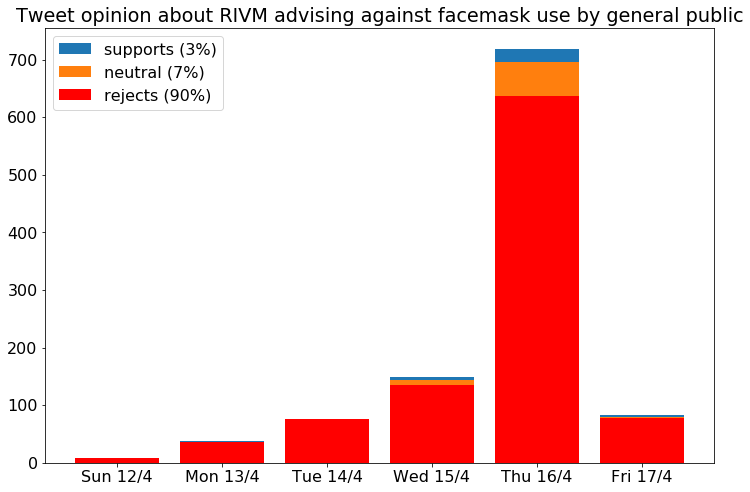

In [26]:
labels = {"NEGATIVE":"rejects","POSITIVE":"supports","NEUTRAL":"neutral"}
percentages = {key:round(100*totals[key]/sum(totals.values())) for key in totals}
font = {"size":16}
matplotlib.rc("font",**font)

for date in labelsPerDate:
    for label in [NEGATIVE,NEUTRAL,POSITIVE]:
        if not label in labelsPerDate[date]:
            labelsPerDate[date][label] = 0

negative = [labelsPerDate[date][NEGATIVE] for date in labelsPerDate.keys()]
neutral = [labelsPerDate[date][NEUTRAL] for date in labelsPerDate.keys()]
positive = [labelsPerDate[date][POSITIVE] for date in labelsPerDate.keys()]
negplusneu = [negative[i]+neutral[i] for i in range(0,len(neutral))]
plt.figure(figsize=(12,8))
plt.bar(list(labelsPerDate.keys()),positive,label=labels[POSITIVE]+" ("+str(percentages[POSITIVE])+"%)",bottom=negplusneu)
plt.bar(list(labelsPerDate.keys()),neutral,label=labels[NEUTRAL]+" ("+str(percentages[NEUTRAL])+"%)",bottom=negative)
plt.bar(list(labelsPerDate.keys()),negative,label=labels[NEGATIVE]+" ("+str(percentages[NEGATIVE])+"%)",color="r")
plt.title("Tweet opinion about RIVM advising against facemask use by general public")
plt.xticks(list(labelsPerDate.keys()),["Fri 17/4","Wed 15/4","Sun 12/4","Thu 16/4","Mon 13/4","Tue 14/4"])
plt.legend()
plt.show()

In [27]:
dates = pd.read_csv(DATESFILENUNL,index_col=ID)[DATE].to_dict()

In [28]:
inFile = open(DATADIR+ANNOTATIONFILENUNL,"r")
annotations = {}
minutes = {}
for line in inFile:
    (userName,date,tweetId,nbr,label) = line.strip().split()
    annotations[tweetId] = label
    minutes[date[0:12]] = True
inFile.close()

In [30]:
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
SUPPORTS = "SUPPORTS"
REJECTS = "REJECTS"
ID = "id"

labelsPerDate = {}
totals = {}
for textId in dates:
    if textId in annotations and annotations[textId] != IRRELEVANT:
        date = dates[textId]
        label = annotations[textId]
        if not date in labelsPerDate: labelsPerDate[date] = {}
        labelsPerDate[date][label] = labelsPerDate[date][label]+1 if label in labelsPerDate[date] else 1
        totals[label] = totals[label]+1 if label in totals else 1

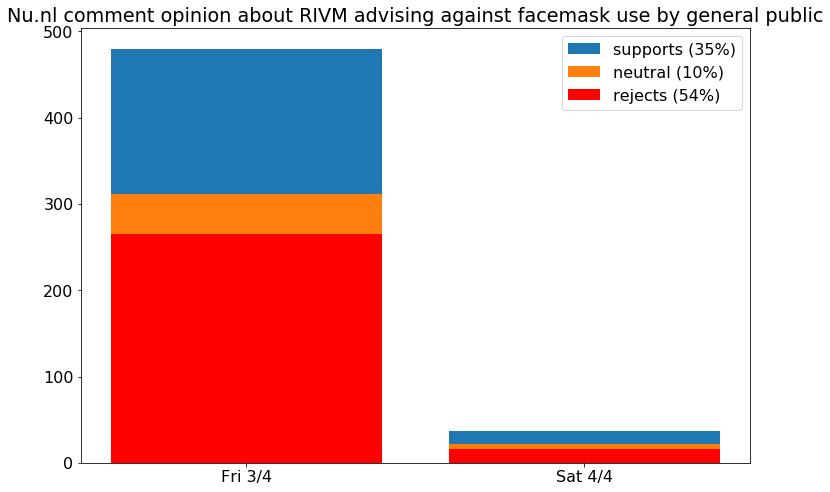

In [31]:
REJECTS = "REJECTS"
SUPPORTS = "SUPPORTS"
NEUTRAL = "NEUTRAL"

labels = {"REJECTS":"rejects","SUPPORTS":"supports","NEUTRAL":"neutral"}
percentages = {key:round(100*totals[key]/sum(totals.values())) for key in totals}
font = {"size":16}
matplotlib.rc("font",**font)

for date in labelsPerDate:
    for label in [REJECTS,NEUTRAL,SUPPORTS]:
        if not label in labelsPerDate[date]:
            labelsPerDate[date][label] = 0

negative = [labelsPerDate[date][REJECTS] for date in sorted(labelsPerDate.keys())]
neutral = [labelsPerDate[date][NEUTRAL] for date in sorted(labelsPerDate.keys())]
positive = [labelsPerDate[date][SUPPORTS] for date in sorted(labelsPerDate.keys())]
negplusneu = [negative[i]+neutral[i] for i in range(0,len(neutral))]
plt.figure(figsize=(12,8))
plt.bar(list(sorted(labelsPerDate.keys())),positive,label=labels[SUPPORTS]+" ("+str(percentages[SUPPORTS])+"%)",bottom=negplusneu)
plt.bar(list(sorted(labelsPerDate.keys())),neutral,label=labels[NEUTRAL]+" ("+str(percentages[NEUTRAL])+"%)",bottom=negative)
plt.bar(list(sorted(labelsPerDate.keys())),negative,label=labels[REJECTS]+" ("+str(percentages[REJECTS])+"%)",color="r")
plt.title("Nu.nl comment opinion about RIVM advising against facemask use by general public")
plt.xticks(list(sorted(labelsPerDate.keys())),["Fri 3/4","Sat 4/4"])
plt.legend()
plt.show()

## 6. Twitter sentiment on a press conference day

In [33]:
sentimentPerHour = pd.read_csv(DATADIR+FILEALL2020,index_col=DATE)

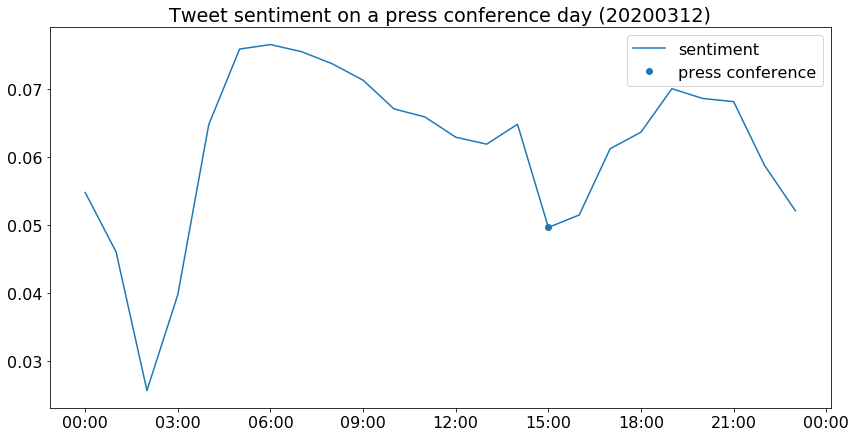

In [32]:
TARGETDATE = "20200312"
PRESSCONFERENCELISTHOUR = ["20200312-15","20200315-17","20200317-18","20200319-18","20200323-19","20200331-19",\
                           "20200407-19","20200415-19","20200421-19","20200429-18","20200506-19","20200513-18",\
                           "20200519-19"]

fig,ax = plt.subplots(figsize=(FIGXSIZE,FIGYSIZE))
lineData = ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in sentimentPerHour.index \
                                                                        if re.search(TARGETDATE,key)],\
                        [sentimentPerHour.loc[key][plotInfo] for key in sentimentPerHour.index \
                                                                if re.search(TARGETDATE,key)],\
                        xdate=True,fmt="-",label="sentiment")
color = lineData[-1].get_color()
ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in PRESSCONFERENCELISTHOUR \
                                                             if re.search(TARGETDATE,key)],
                         [sentimentPerHour.loc[key][plotInfo] for key in PRESSCONFERENCELISTHOUR\
                                                                 if re.search(TARGETDATE,key)],\
                         fmt="o",color=color,label=PRESSCONFERENCE)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.title("Tweet sentiment on a press conference day ("+TARGETDATE+")")
dummy = ax.legend()